In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import imp
import copy

import hyperspy.api as hs

C:\Users\HERMES\AppData\Local\Temp\ipykernel_18204\3373179254.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


'hs=imp.load_source("hyperspy", "/home/corentin/data/Github/hyperspy-RELEASE_next_minor/hyperspy/__init__.py")\nhs=imp.load_source("hyperspy.api", "/home/corentin/data/Github/hyperspy-RELEASE_next_minor/hyperspy/api.py")'

In [2]:
import sys
# path to load the specific routines
sys.path.append(r'/ """ add your own path here""" /Quantorxs_for_HS')
sys.path.append(r'/""" add your own path here""" /CL_Quant')

from Quantorxs_for_HS import*
from load_STXM import *
from extract_signal import*

# Load and Align

In [3]:
filename = "Sample_Stack_2024-02-07_194.hdf5"

In [4]:
s =load_STXM(filename, shift=1.72, number_of_region=1)

In [6]:
s[0].plot()

In [5]:
im = s[0].deepcopy()

## Decomposition for alignements

In [8]:
im.transpose().plot()

In [6]:
im.decomposition(True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


In [11]:
im.plot_explained_variance_ratio()

<Axes: title={'center': '\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

In [10]:
im.plot_decomposition_results()

In [7]:
sdec = im.get_decomposition_model(5)

In [8]:
sdec.plot()

## alignments

In [6]:
shifts = im.estimate_shift2D(reference = "cascade", hanning = True, sobel = True, medfilter = False,
           #roi=(120, 164, 1, 36),
           chunk_size = 30, normalize_corr = True, correlation_threshold = None, sub_pixel_factor=30)

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
im.align2D(shifts = shifts)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)
[########################################] | 100% Completed | 107.20 ms


In [10]:
im.plot()

In [29]:
# after iterating the alignments, apply all shifts to un-decomposed dataset
im.align2D(shifts = shifts+shifts2+shifts3)

[########################################] | 100% Completed | 106.56 ms


In [30]:
im.plot()

In [ ]:
im.save('align.hspy')

In [28]:
im=hs.load('align.hspy')

ValueError: No filename matches the pattern "align.hspy"

# Defining Io and normalize signal to it

## Defining Io

### From dedicated stack region

In [9]:
s[1].plot()

In [26]:
io = s[1].transpose().mean()

### From an image based on sum of the intensities at all energies

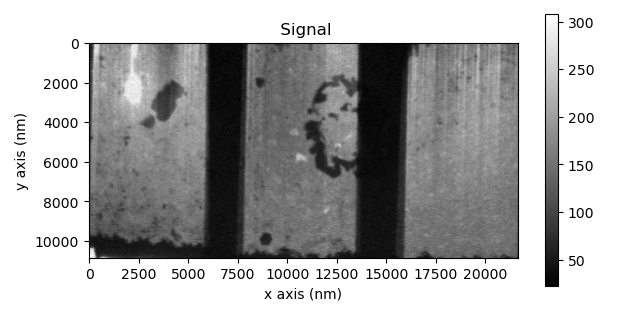

In [11]:
s_int = im.transpose().integrate1D(-1)
s_int.T.plot()

#### Entering threshold

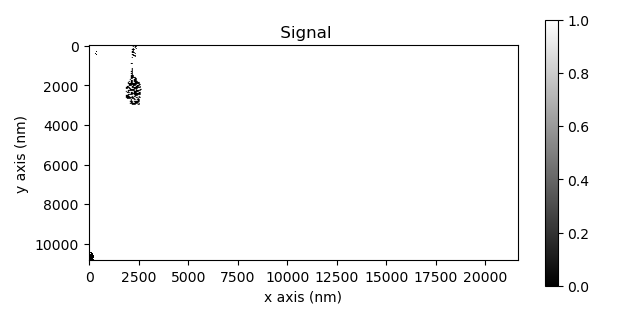

In [12]:
M_io = s_int<280
M_io.T.plot()

#### Creating and plotting the Io spectrum (from mask)

In [13]:
def extract_spectra(s, mask, plot=True, mode = 'mean'):
    """This function allows to extract a spectra from a masked signal
    ** s : the signal
    ** M : the mask to apply
    ** mode : the spectra can be either 'mean' or 'sum' of all unmasked pixels"""

    import copy
    import numpy as np
    s_M = copy.deepcopy(s)
    s_M.data[mask.data, :] = np.nan
    if mode == 'mean':
        sp = s_M._get_signal_signal(np.nanmean(s_M.data, axis=(0, 1)))
    
    elif mode== 'sum':
        sp = s_M._get_signal_signal(np.nansum(s_M.data, axis=(0, 1)))
    
    #sp.metadata=s.metadata
    if plot ==True: sp.plot(True)
    return sp


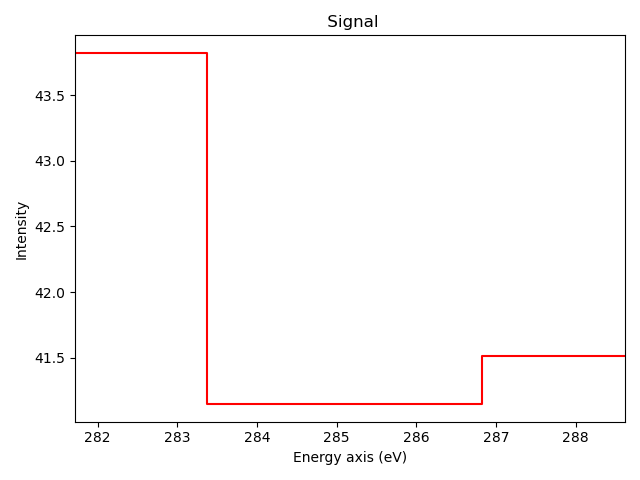

In [14]:
io = extract_spectra(im.transpose(), M_io, mode='mean')

In [12]:
io.save('io')

In [42]:
io = hs.load('io.hspy')

## Switching to Optical density

In [15]:
s_od = -np.log(im.transpose()/io)
s_od.plot()

In [46]:
s_od.save('s_od')

# Rapid view (spectra, map)

## Plotting a combined map

#### Masking the empty and the thick regions

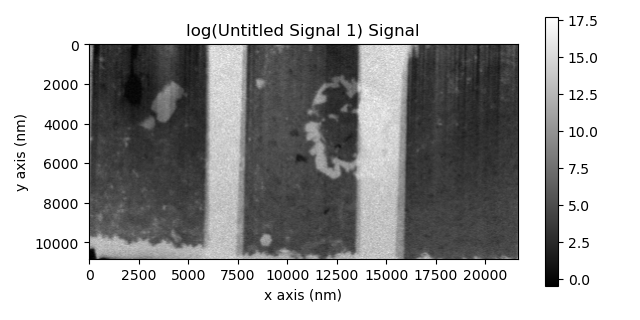

In [25]:
s_od.integrate1D(-1).T.plot()

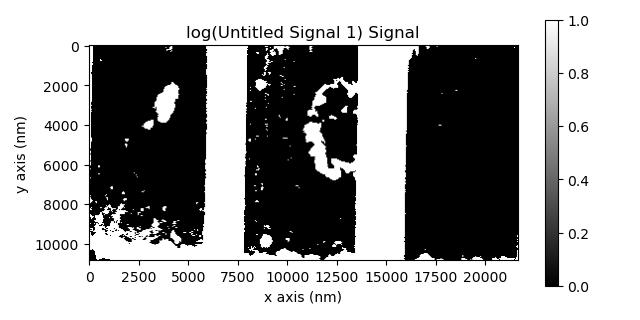

In [28]:
M_thick = s_od.integrate1D(-1)>6
M_thick.T.plot()

In [32]:
C1 = s_od.isig[2]-s_od.isig[0]
C2 = s_od.isig[1]-s_od.isig[0]

"C1.metadata.General.title = '285-280'\nC2.metadata.General.title = '287.5-280'\nC2 = C2-C1\nC3.metadata.General.title = '288.6-280'\nC3 = C3-C1"

In [ ]:
M = M_io+M_thick

In [33]:
C1N = copy.deepcopy(C1)/np.nanmax(C1.data)
C1N.data[(M).data] = np.nan
C2N = copy.deepcopy(C2)/np.nanmax(C2.data)
C2N.data[(M).data] = np.nan

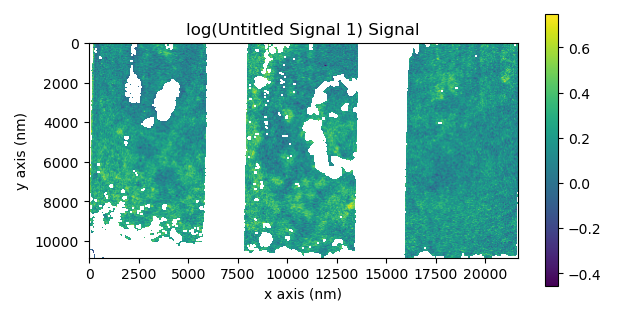

In [46]:
C1N.T.plot(cmap='viridis')

In [47]:
plt.gcf()
plt.savefig('MapStacks1.png', bbox_inches = 'tight')

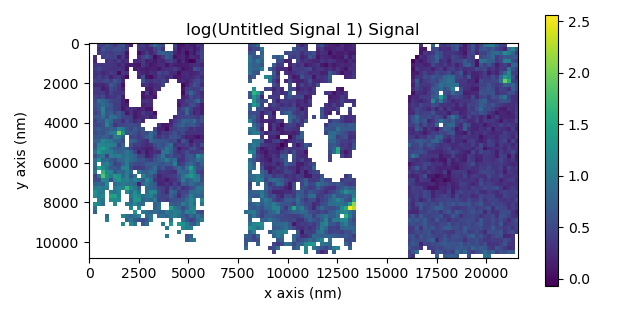

In [55]:
(C2N.rebin((433/4, 217/4))/4).T.plot(cmap='viridis')

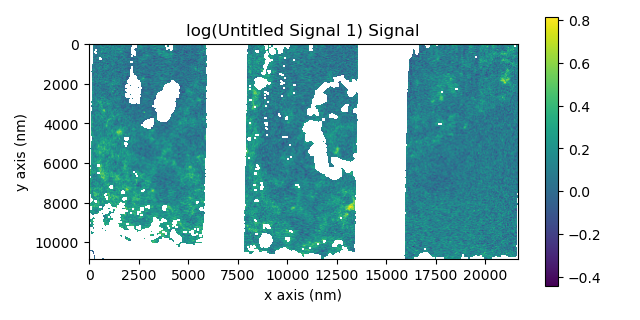

In [48]:
C2N.T.plot(cmap='viridis')

In [49]:
plt.gcf()
plt.savefig('MapStacks2.png', bbox_inches = 'tight')

### Creating the map

In [232]:
G=[C1N, C2N,C3N]
G = hs.hyperspy.utils.stack(G)

[########################################] | 100% Completed |  0.1s


#### Nombre de composant, leurs noms, et leurs couleurs

In [233]:
N=3
phases=['Aromatics', 'Aliphatics-Aromatics', 'Carboxylics-Aromatics']
colorscale = np.array([[228/255, 26/255, 28/255],
                       [55/255, 126/255, 184/255], 
                       [77/255, 175/255, 74/255],
                       #[255/255, 127/255, 0/255]
                      ]) #, [1,1,0],[1,0,1],[0.5,0.3,0.3],[0.3,0.5,0.3],[0.3,0.3,0.5], [0.5,0.5,0.5], [0.15, 0.15, 0.85]])

In [ ]:
plot_color_map(3, G, legend, colorscale)

# Modelling and substracting background

In [3]:
s_od = hs.load('s_od.hspy')
s_od

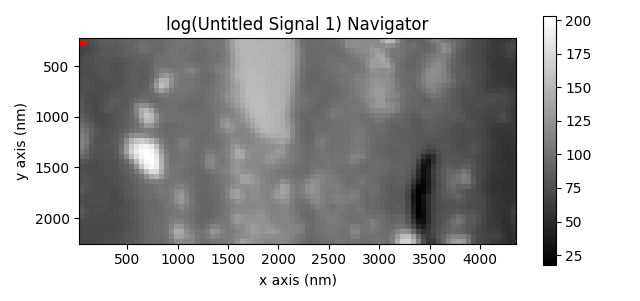

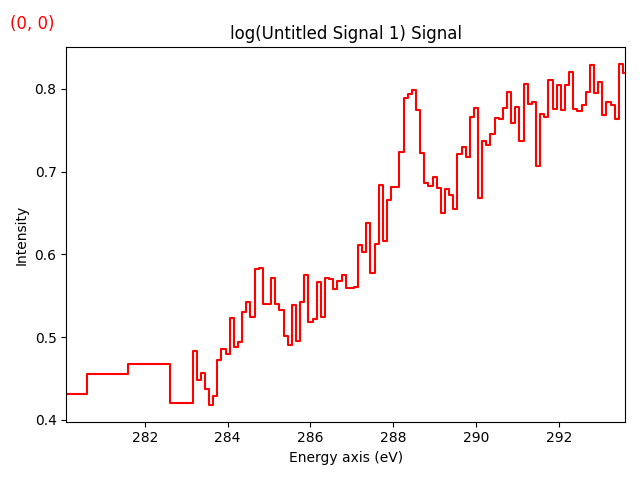

In [10]:
s_od.isig[280.:295.].plot()

## Masking before fitting : holes, thick and undesired regions

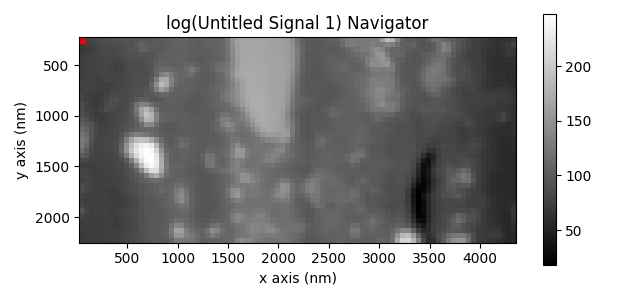

In [4]:
s_od.integrate1D(-1).plot()

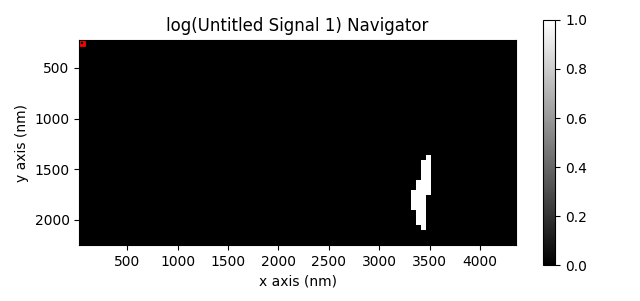

In [5]:
M_trou = s_od.integrate1D(-1)<45
M_trou.plot()

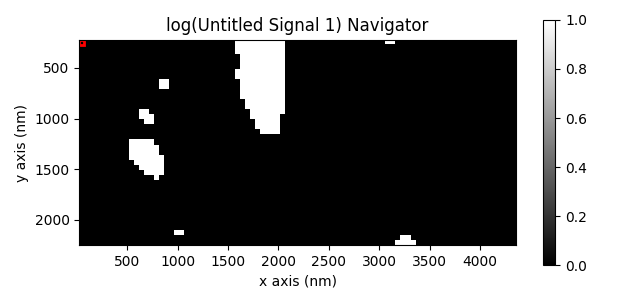

In [6]:
M_thick = s_od.integrate1D(-1)>160
M_thick.plot()

## Background subtraction and normalization to the total amount of carbons_od

In [52]:
%%time
s_od_back, s_od_norm, C_map, m = background_and_normalize(s_od, signal_range=[255.2, 281.], 
                                                         #  Pix_init=[29,22], # divergent fitting can be solved by initializing the gaussian height to one specific pxel (for which it works)
                                                          mask=(M_trou).data
                                                         )

  0%|          | 0/3532 [00:00<?, ?it/s]

model has been fitted, creating a background subtracted signal, a Carbon normalized signal and a carbon map
CPU times: user 10min 12s, sys: 2.29 s, total: 10min 15s
Wall time: 10min 13s


/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/signal.py:2300: RuntimeWarning: invalid value encountered in true_divide
  ns.data = getattr(sdata, op_name)(odata)


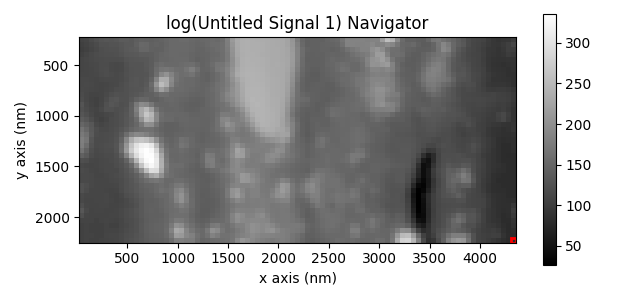

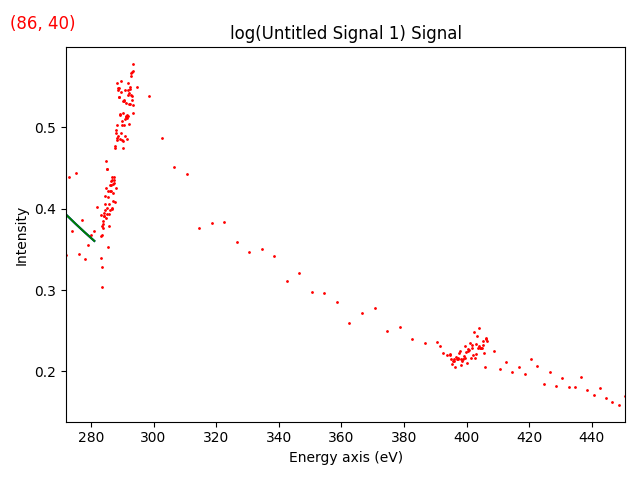

In [53]:
m.plot(True)

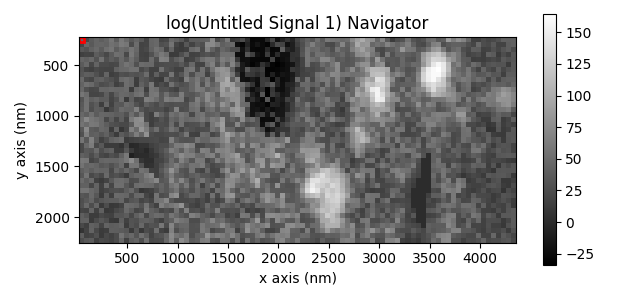

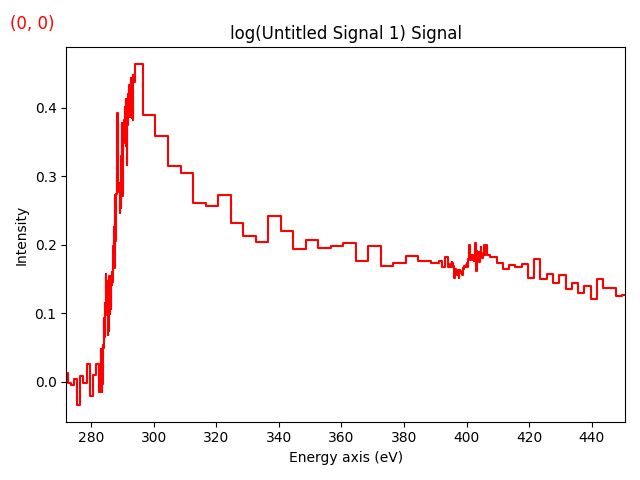

In [54]:
s_od_back.plot()

In [55]:
C_map.save('C_map')
s_od_norm.save('s_od_norm')
s_od_back.save('s_od_back')
m.save_parameters2file('m_back')

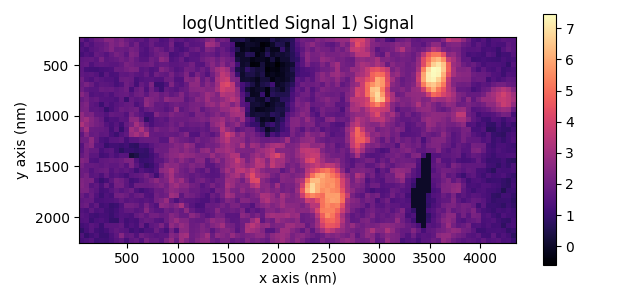

In [56]:
C_map.transpose().plot(cmap = 'magma')

## Quantorxsing

In [57]:
%%time
mf, Qtx = Quantorxs(s_od_norm, 
                    mask=(M_trou).data
                   )

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/model.py:1890: VisibleDeprecationWarning: The `iterpath` default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change the 'iterpath' argument to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/3532 [00:00<?, ?it/s]

CPU times: user 16min 3s, sys: 2.56 s, total: 16min 5s
Wall time: 16min 3s


/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


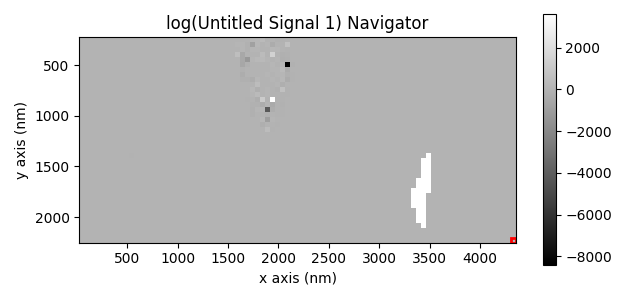

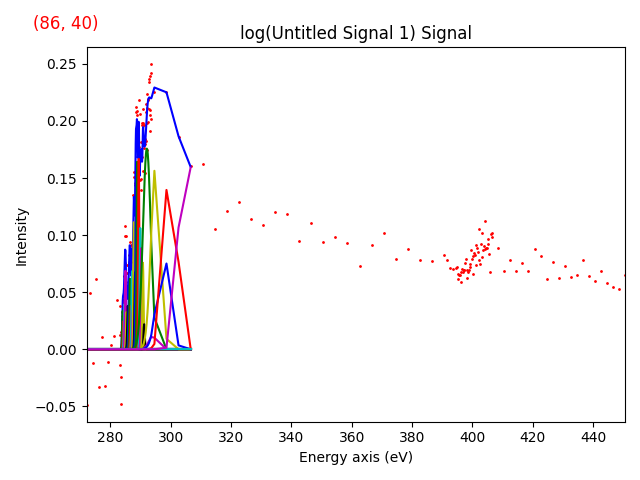

In [58]:
mf.plot(True)

In [59]:
mf.save_parameters2file('fit_quantorxs')

In [27]:
mf.load_parameters_from_file('fit_quantorxs_dec.npz')

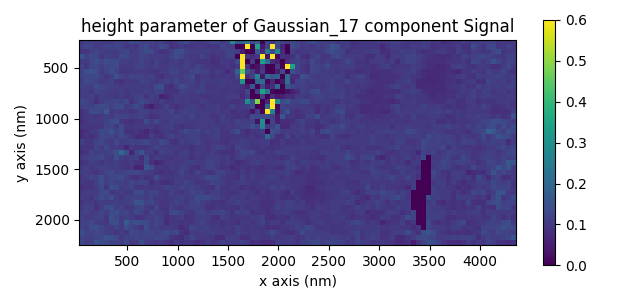

In [60]:
mf['Gaussian_17'].height.as_signal().plot(cmap='viridis', vmax=0.6)

In [61]:
Q=hs.hyperspy.utils.stack(Qtx)
Q.save('Quantified_maps')

[########################################] | 100% Completed | 101.90 ms


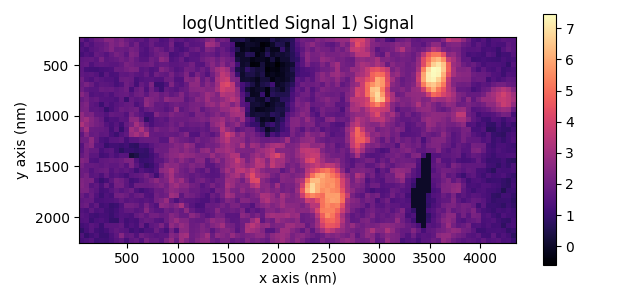

In [62]:
C_map.transpose().plot(cmap='magma')

In [63]:
for i in range(len(Qtx)):
    Qtx[i].data[(M_trou).data]=np.nan #+M_thick
    Qtx[i].data[(Qtx[i].data<0).data]=np.nan
    C_map.data[(Qtx[i].data<0).data]=np.nan
    Qtx[i].data[(Qtx[i].data>100).data]=np.nan
    C_map.data[(Qtx[i].data>100).data]=np.nan

C_map.data[(M_trou).data]=np.nan #+M_thick
C_map.data[(C_map.data>100).data]=np.nan
C_map.data[(C_map.data<0).data]=np.nan

In [64]:
Qtx[0].metadata.General.title = 'Aromatics+Olefinics (at.%)'
Qtx[1].metadata.General.title = 'Ketones+Phenols+Nitriles (at.%)'
Qtx[2].metadata.General.title = 'Aliphatics (at.%)'
Qtx[3].metadata.General.title = 'Carboxylics (at.%)'

C_map.metadata.General.title = 'Carbon content (a.u.)'
#Ca_map.metadata.General.title = 'Calcium content (a.U)'

In [65]:
Q=hs.hyperspy.utils.stack(Qtx)
Q.save('Quantified_maps')

[########################################] | 100% Completed | 101.76 ms


Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/Quantified_maps.hspy' (y/n)?
 y


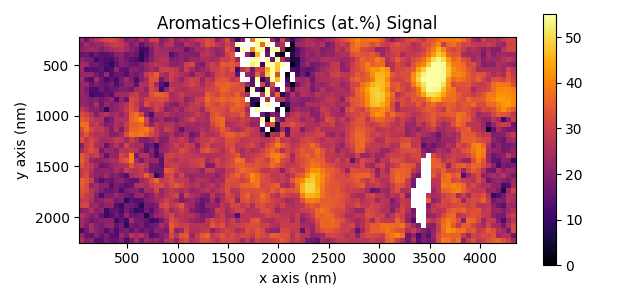

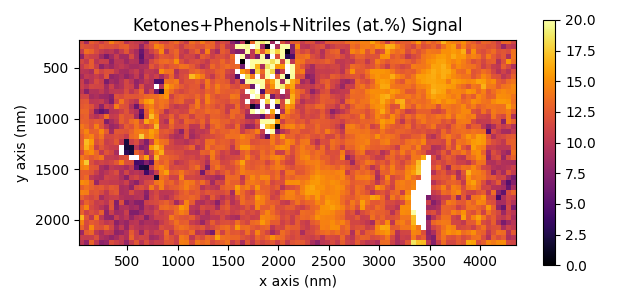

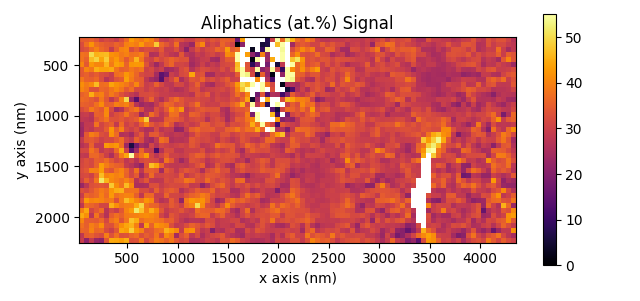

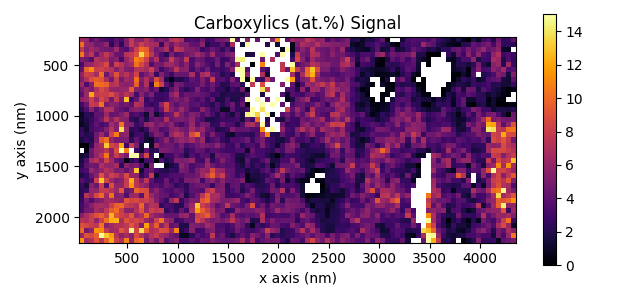

In [66]:
Qtx[0].plot(cmap='inferno', vmin=0., vmax=55.)
fig = plt.gcf()
fig.savefig('Qtx_Aromatics.png', dpi=500, bbox_inches='tight')
Qtx[1].plot(cmap='inferno', vmin=0., vmax=20.)
fig = plt.gcf()
fig.savefig('Qtx_Ketones.png', dpi=500, bbox_inches='tight')
Qtx[2].plot(cmap='inferno', vmin=0., vmax=55.)
fig = plt.gcf()
fig.savefig('Qtx_Aliphatics.png', dpi=500, bbox_inches='tight')
Qtx[3].plot(cmap='inferno', vmin=0., vmax=15.)
fig = plt.gcf()
fig.savefig('Qtx_Carboxylics', dpi=500, bbox_inches='tight')

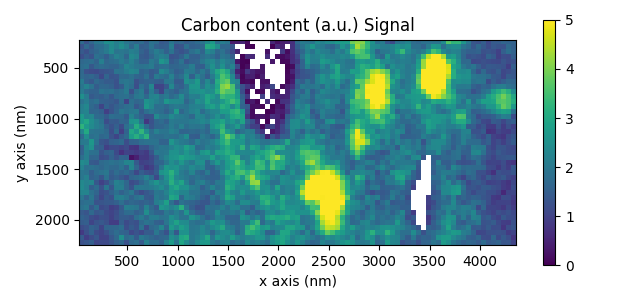

In [67]:
C_map.transpose().plot(cmap='viridis', vmin=0., vmax=5.)
fig = plt.gcf()
fig.savefig('C_map.png', dpi=500, bbox_inches='tight')

# Reload it all

In [7]:
s_od_back=hs.load('s_od_back.hspy')
s_od_norm=hs.load('s_od_norm.hspy')
C_map=hs.load('C_map.hspy')
Q= hs.load('Quantified_maps.hspy')

In [16]:
M_part=hs.load('M_part.hspy')
M_diff = hs.load('M_diff.hspy')

# Decomposition

In [68]:
s_od_norm.decomposition(navigation_mask=(M_trou))

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


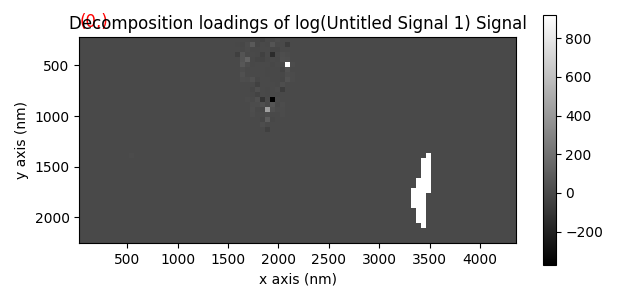

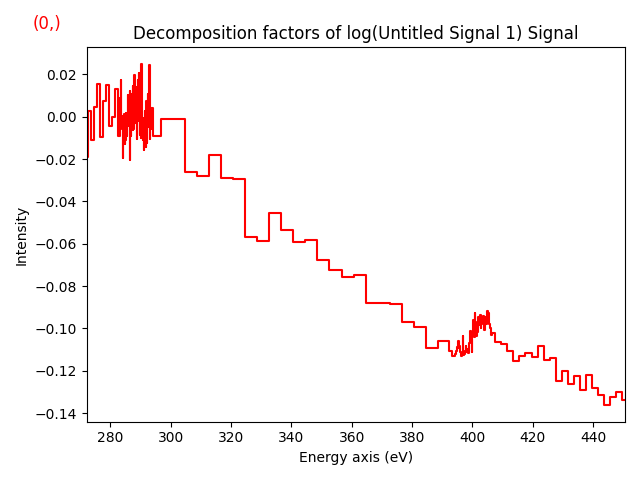

In [69]:
s_od_norm.plot_decomposition_results()

<AxesSubplot:title={'center':'log(Untitled Signal 1)\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

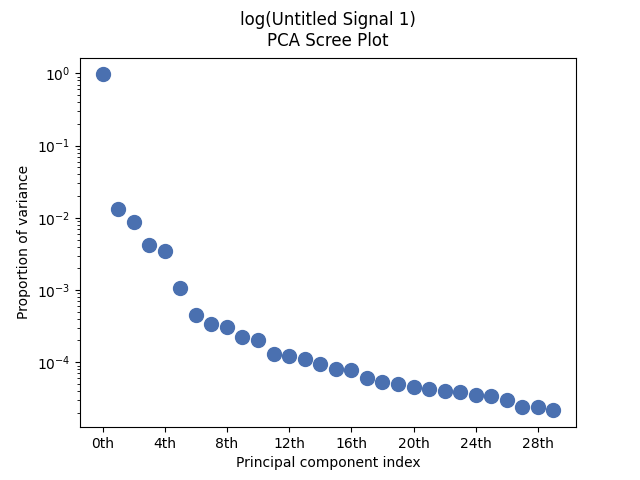

In [70]:
s_od_norm.plot_explained_variance_ratio()

In [71]:
s_od_norm.blind_source_separation(6)

[########################################] | 100% Completed | 102.16 ms


Blind source separation info:
  number_of_components=6
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


/home/corentin/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


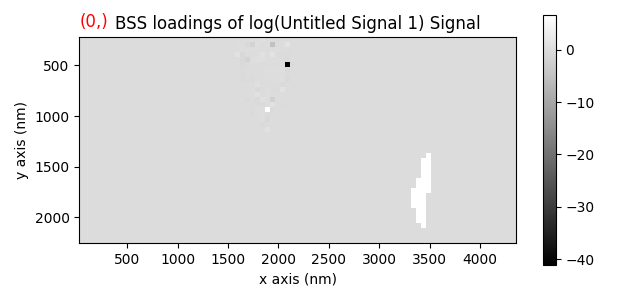

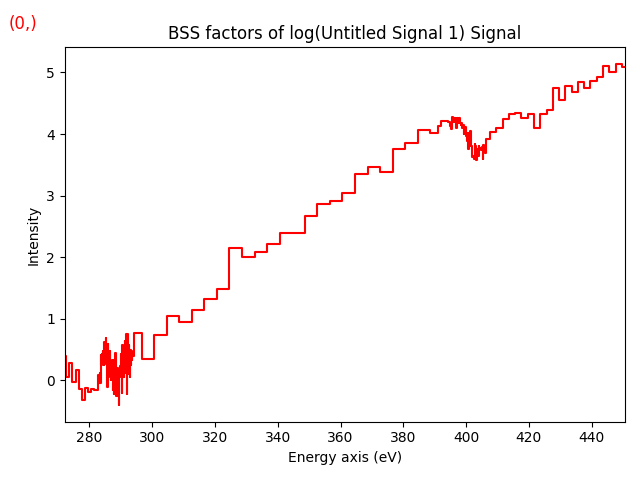

In [72]:
s_od_norm.plot_bss_results()

# Plotting the Quantified Data 

## 2D

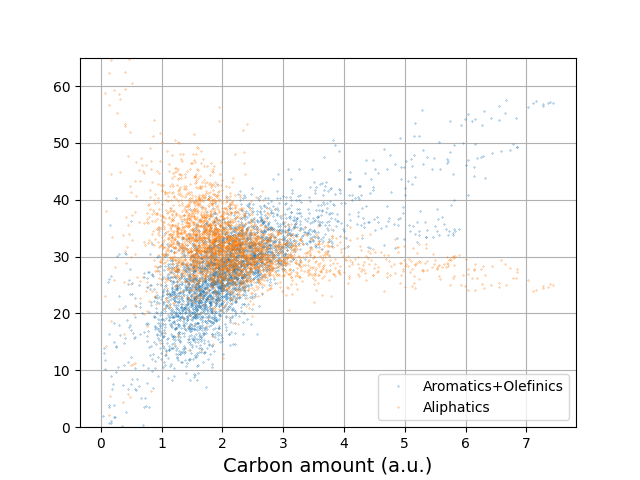

In [98]:
plt.figure()
plt.plot(C_map.data.flatten(), Q.inav[0].data.flatten(), '.', label = 'Aromatics+Olefinics', markersize = 0.5)
plt.plot(C_map.data.flatten(), Q.inav[2].data.flatten(), '.', label = 'Aliphatics',  markersize = 0.5)

plt.xlabel('Carbon amount (a.u.)', size=14)
plt.ylim(00., 65.)
#plt.legend()
plt.grid()
plt.legend()
plt.gcf()
plt.savefig('AroAli_vs_C_map.png', dpi=500, bbox_inches='tight')

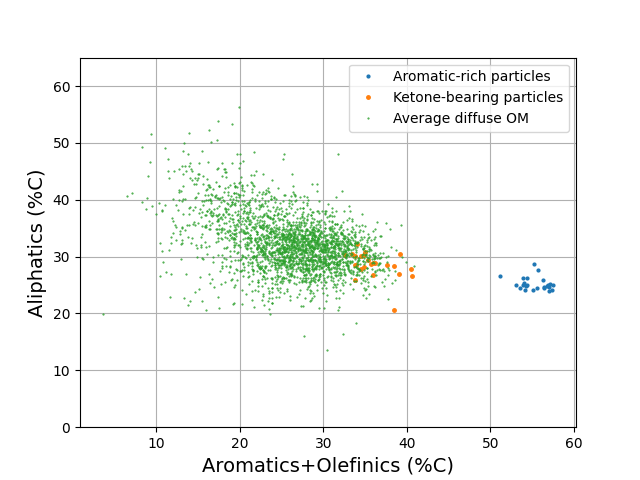

In [37]:
plt.figure()
plt.plot(Q.inav[0].data[~M_part1].flatten(), Q.inav[2].data[~M_part1].flatten(), '.', label=legend[0], markersize = 4)
plt.plot(Q.inav[0].data[~M_part2].flatten(), Q.inav[2].data[~M_part2].flatten(), '.', label=legend[1], markersize = 5)
plt.plot(Q.inav[0].data[~M_diff].flatten(), Q.inav[2].data[~M_diff].flatten(), '.', label=legend[2],  markersize = 1)
plt.xlabel('Aromatics+Olefinics (%C)', size=14)
plt.ylabel('Aliphatics (%C)', size=14)

plt.ylim(00., 65.)
plt.grid()
plt.legend()
plt.gcf()
plt.savefig('Aro_vs_Ali.png', dpi=500, bbox_inches='tight')

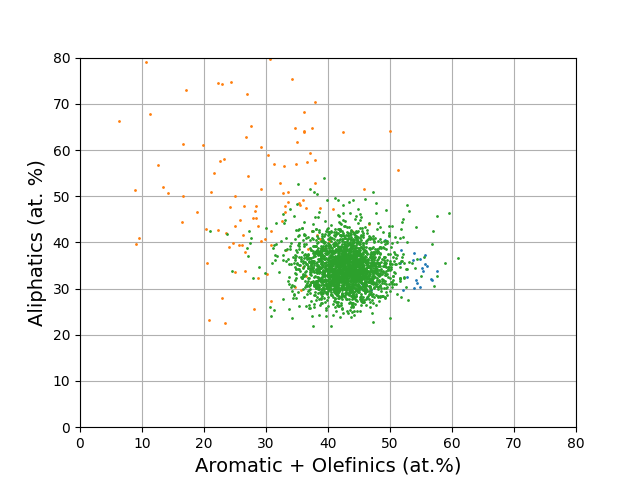

In [285]:
plt.figure()
#plt.plot(Q.inav[0].data.flatten(), Q.inav[2].data.flatten(), '.' , label = 'Aliphatics', markersize = 2 )
plt.plot(Q.inav[0].data[~m1.data].flatten(), Q.inav[2].data[~m1.data].flatten(), '.' , label = 'Aliphatics', markersize = 2 )
plt.plot(Q.inav[0].data[~m2.data].flatten(), Q.inav[2].data[~m2.data].flatten(), '.' , label = 'Aliphatics', markersize = 2 )
plt.plot(Q.inav[0].data[~m3.data].flatten(), Q.inav[2].data[~m3.data].flatten(), '.' , label = 'Aliphatics', markersize = 2 )

plt.xlabel('Aromatic + Olefinics (at.%)', size=14)
plt.ylabel('Aliphatics (at. %)', size=14)
plt.xlim(0., 80.)
plt.ylim(0., 80.)
plt.grid()

plt.gcf()
plt.savefig('Aro_vs_Ali.png', dpi=500, bbox_inches='tight')

## Ternary

In [1]:
Ternary_Contour([
    [Q.inav[0], Q.inav[1], Q.inav[2]], 
                 [Q.inav[1], Q.inav[1], Q.inav[2]],
        #[Q.inav[0], Q.inav[1], Q.inav[2]], 
    #[Q.inav[0], Q.inav[1], Q.inav[2]], 
],
               mask=[M_part, M_diff], 
                legend=['Particles', 'Diffuse'],
        type = 'Organics',
        cmap = ['Blues', 'Reds', 'Greens', 'Purples', 'Greys', ],
                 levels = 7,
                 alpha = 0.5,
                 ContourValues='n', ContLines='y', ContColourFill='y', DataPointDisp='n',)

"""plt.xlim(0, 0.3)
plt.ylim(0.3, 0.55)"""

NameError: name 'Ternary_Contour' is not defined

In [149]:
plt.gcf()
plt.savefig('tri.pdf', bbow_inches='tight')
plt.savefig('tri.png', bbow_inches='tight')

/tmp/ipykernel_341087/1911510585.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbow_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('tri.pdf', bbow_inches='tight')
/tmp/ipykernel_341087/1911510585.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbow_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('tri.png', bbow_inches='tight')


## Histos

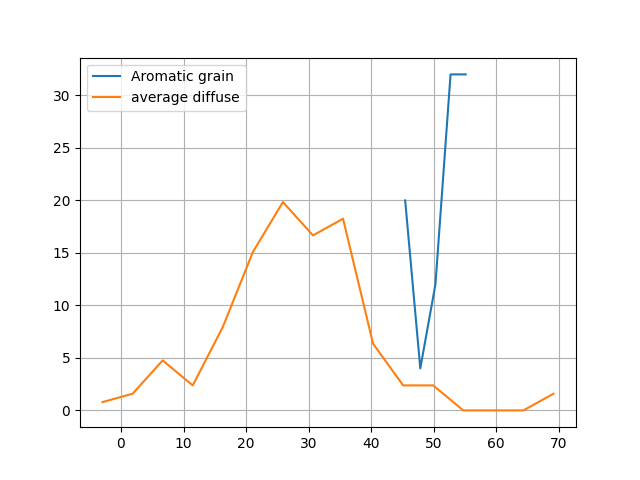

In [297]:
plot_histo([
    Q.inav[0],Q.inav[0]
],
    mask = [m1, m2],
legend=legend, linestyle = ['-','-'],
)

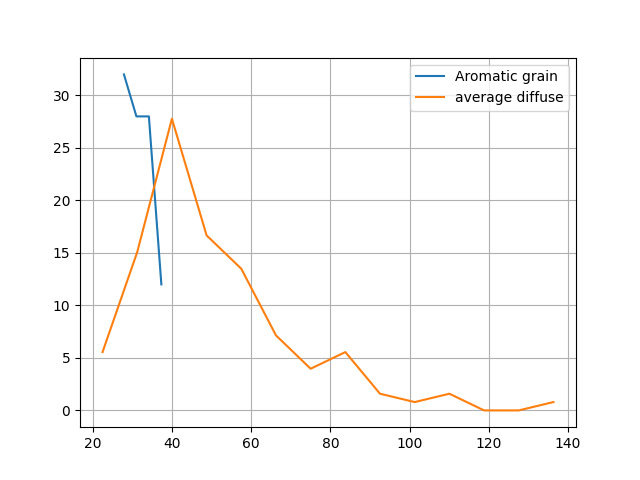

In [298]:
plot_histo([
    Q.inav[2],Q.inav[2]
],
    mask = [m1, m2],
legend=legend, linestyle = ['-','-'],
)

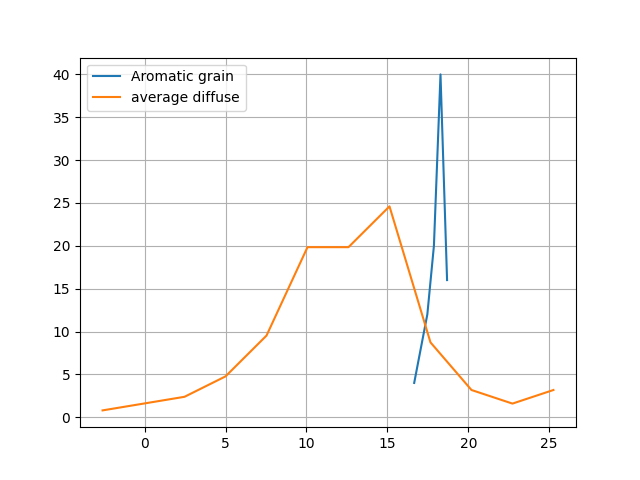

In [299]:
plot_histo([
    Q.inav[1],Q.inav[1]
],
    mask = [m1, m2],
legend=legend, linestyle = ['-','-'],
)

# Masking to extract end member spectra

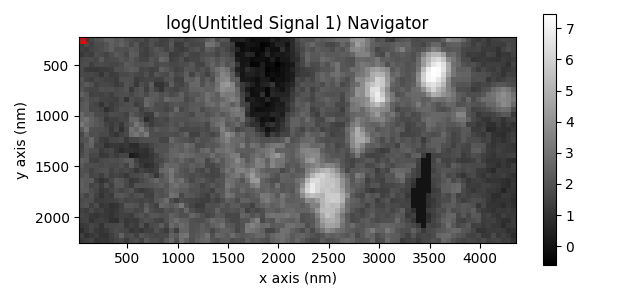

In [17]:
C_map.plot()

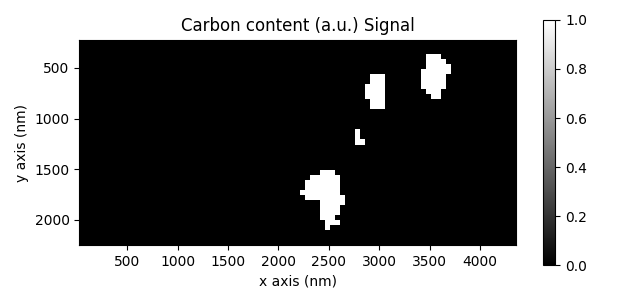

In [133]:
M1=C_map.transpose()>4.5
M1.plot()

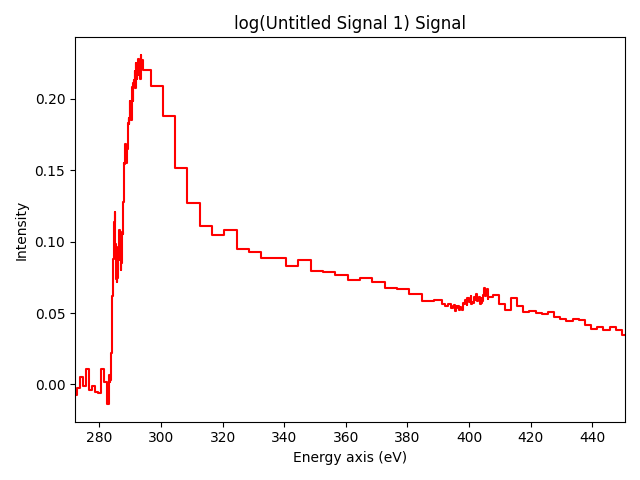

In [27]:
sp1 = s_od_norm.inav[50,31]
sp1.plot()

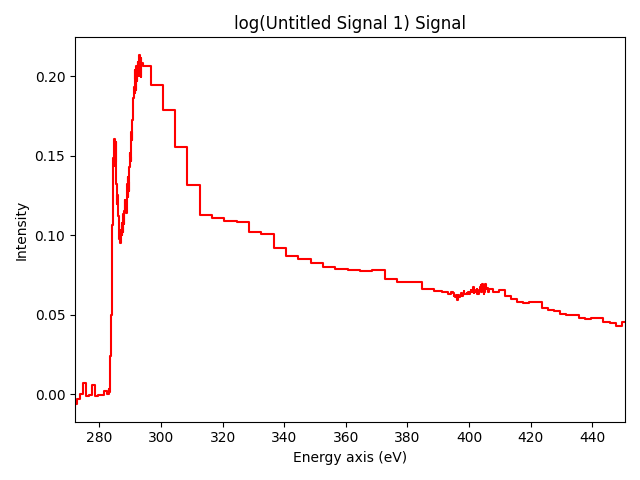

In [28]:
sp2 = s_od_norm.inav[70,6]
sp2.plot()

In [29]:
sp1.save('OM_Particles_ket')
sp2.save('OM_particles_aro')

Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/OM_Particles_ket.hspy' (y/n)?
 y
Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/OM_particles_aro.hspy' (y/n)?
 y


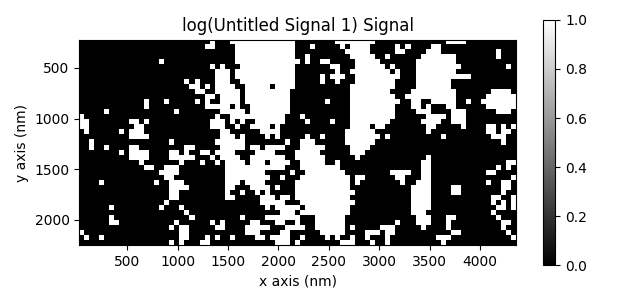

In [51]:
Ma=C_map.transpose()<1.
Mb=C_map.transpose()>2.5

M2 = Ma+Mb+(M_trou).transpose()
M2.plot()

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


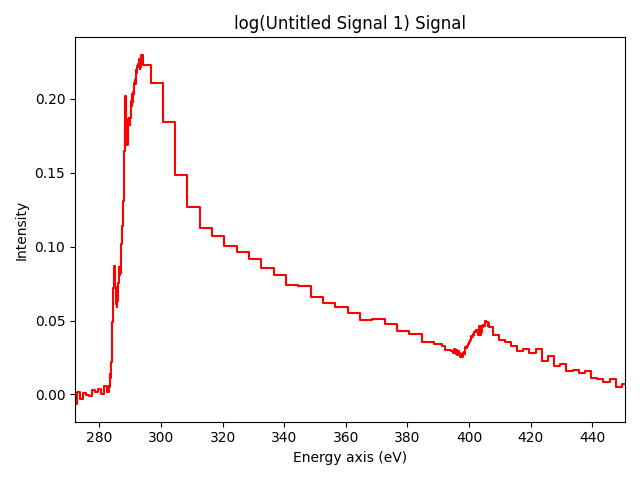

In [55]:
sp3 = extract_spectra(s_od_norm, M2)

In [150]:
sp3.save('Diffuse_OM')

Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/Diffuse_OM.hspy' (y/n)?
 y


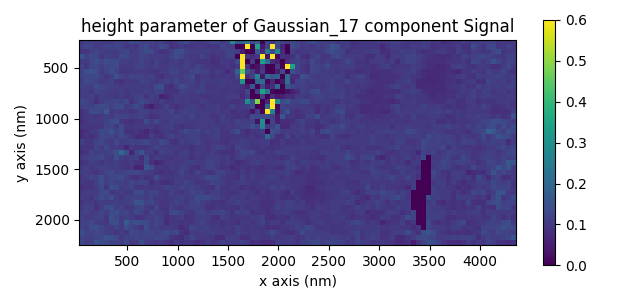

In [106]:
mf['Gaussian_17'].height.as_signal().plot(cmap='viridis', vmax=0.6)

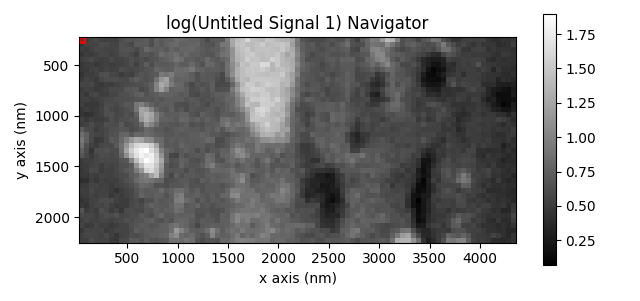

In [19]:
s_od.isig[273.].plot()

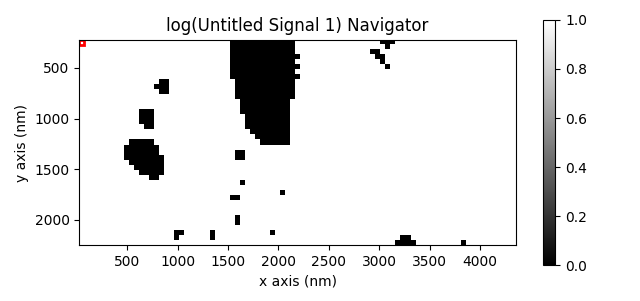

In [20]:
M3 = s_od.isig[273.]<1
M3.plot()

In [92]:
legend=['Particles_Aromatic','Particles_with ketones','Average diffuse']

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(


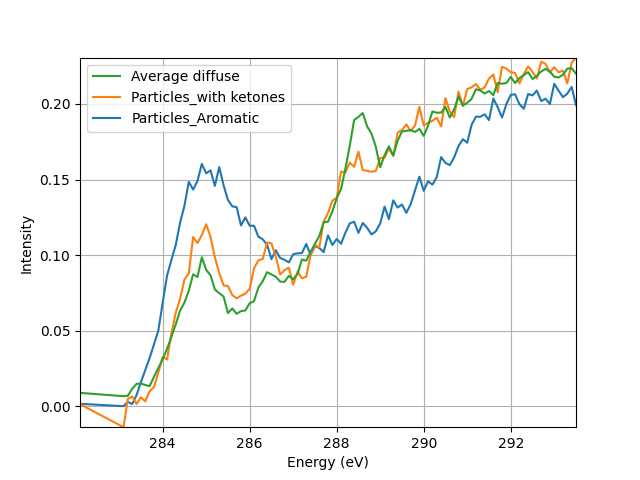

In [93]:
hs.plot.plot_spectra([sp1.isig[282.:294.], 
                      sp2.isig[282.:294.],
                       sp3.isig[282.:294.], 
],
                     legend=legend,
                    legend_loc='upper left')
plt.grid()

In [155]:
plt.gcf()
plt.savefig('Main_spectra.png')

# Fitting a linear combination of spectra

In [32]:
sp_part1 = hs.load('OM_particles_aro.hspy')
sp_part2 = hs.load('OM_Particles_ket.hspy')
sp3 = hs.load('Diffuse_OM.hspy')

In [113]:
N=3
S = [sp_part1, sp_part2, sp_diff]

In [114]:
m = s_od_norm.create_model() #False,False
m.set_signal_range((282., 293.))

In [115]:
# On défini les composants au model qui correspondent aux spectres de ref
g = []
for i in range (N):
    g.append(hs.model.components1D.ScalableFixedPattern(S[i]))
    m.extend([g[i]])
    m.set_parameters_not_free([g[i]], parameter_name_list=['xscale','shift'])#On fixe les parametres xscale et shift, pour qu'il n'y ait que la hauteur qui soit ajustable.
    g[i].yscale.bmin=0    #On fixe les bornes min et max des alpha.
    g[i].yscale.bmax=1

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/drawing/utils.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**kwargs)


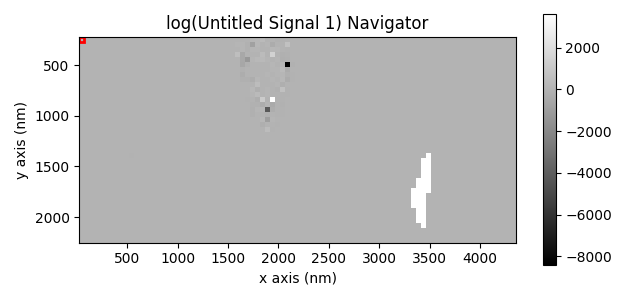

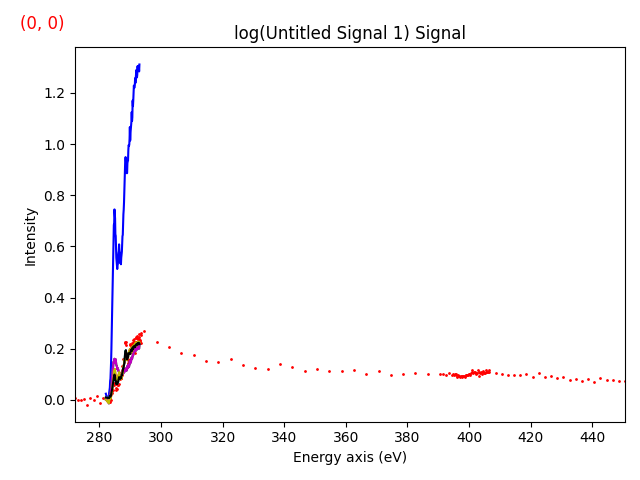

In [39]:
m.plot(True)

In [40]:
m.fit(bounded=True)

   covar: array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.44906518, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])
     dof: 95
   fnorm: 0.029200211723980796
 message: ''
    nfev: 298
     nit: 42
  perror: array([0.        , 0.        , 0.67012326, 0.        , 0.        ,
       0.        ])
  status: 1
 success: True
       x: array([0.        , 0.        , 0.05212164, 0.        , 0.        ,
       1.        ])

In [41]:
m.assign_current_values_to_all()

In [116]:
m.multifit(bounded = True, iterpath = 'serpentine',
           mask =(M_trou+M_thick).transpose().data, 
          )

  0%|          | 0/3315 [00:00<?, ?it/s]

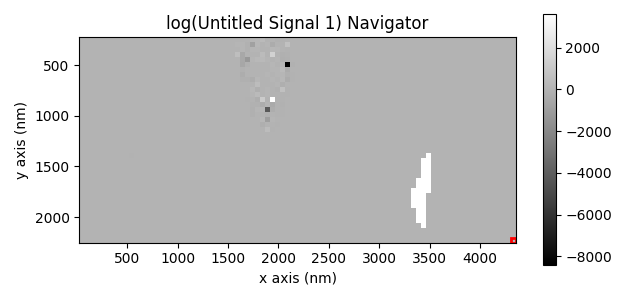

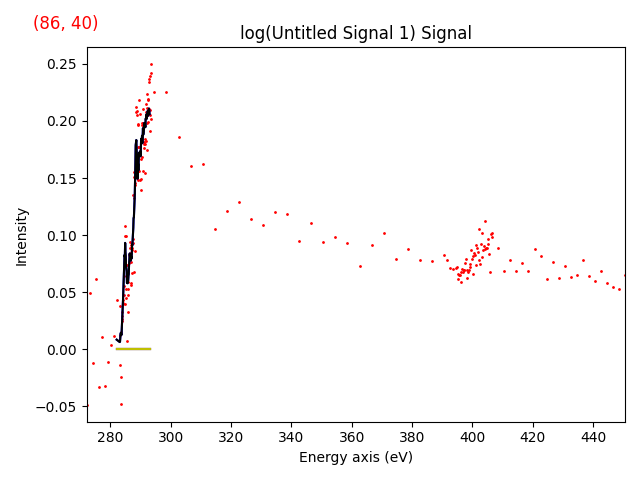

In [67]:
m.plot(True)

In [117]:
G = []
for i in range(N): G.append(g[i].yscale.as_signal())
G=hs.stack(G)
#G.data=np.where(M_thick==1, np.nan, G.data)
G.data=np.where(M_trou==1, np.nan, G.data)

[########################################] | 100% Completed | 105.10 ms
[########################################] | 100% Completed | 102.95 ms


In [119]:
G.save('Map_mixing_model')

Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/Map_mixing_model.hspy' (y/n)?
 y


In [36]:
G = hs.load('Map_mixing_model.hspy')

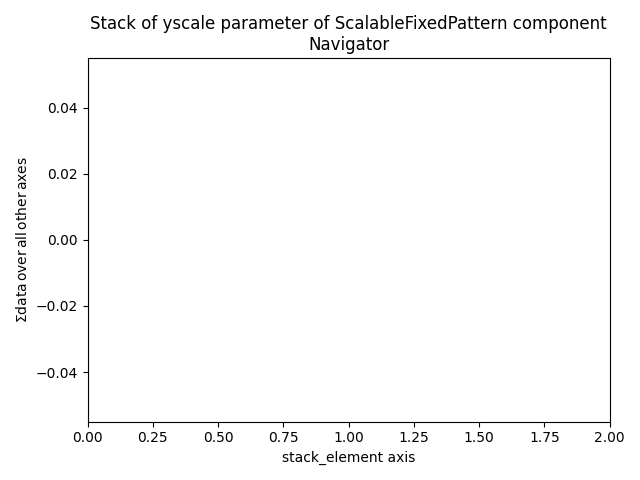

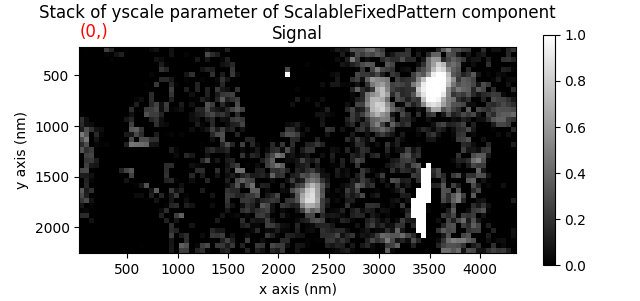

In [118]:
G.plot()

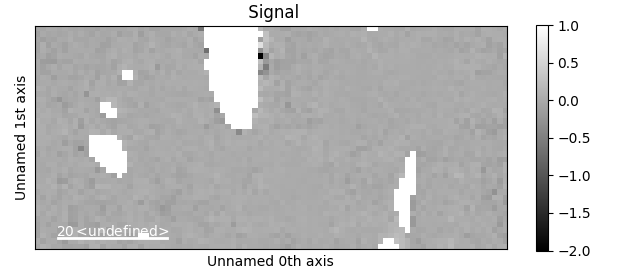

In [120]:
tot = hs.signals.BaseSignal(G.data[0,:,:])+hs.signals.BaseSignal(G.data[1,:,:])+hs.signals.BaseSignal(G.data[2,:,:]) #+hs.signals.BaseSignal(G.data[3,:,:])

res1 = copy.deepcopy(tot)
res1.data = np.array(1-tot.data)
res1.plot(vmax=None)

In [121]:
phases=legend
colorscale = np.array([[55/255, 126/255, 184/255], 
                       [255/255, 127/255, 0/255],
                        [77/255, 175/255, 74/255],
                        [228/255, 26/255, 28/255],
                      ]) #, [1,1,0],[1,0,1],[0.5,0.3,0.3],[0.3,0.5,0.3],[0.3,0.3,0.5], [0.5,0.5,0.5], [0.15, 0.15, 0.85]])

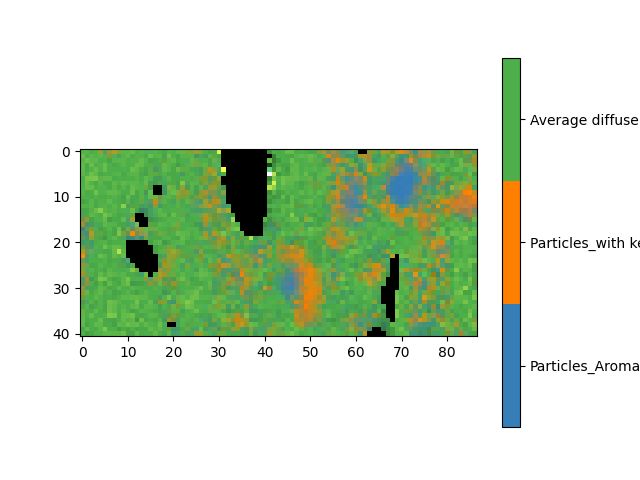

In [122]:
plot_color_map(3, G, legend, colorscale)

In [123]:
plt.gcf()
plt.savefig('Map_mixing_model.png', bbox_inches="tight")
plt.savefig('Map_mixing_model.pdf', bbox_inches="tight")

# Redefine spectra based on mixing model

In [8]:
G=hs.load('Map_mixing_model.hspy')

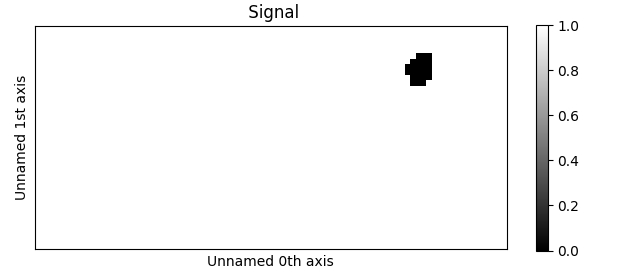

In [9]:
H = hs.signals.BaseSignal(G.data[0,:,:])
M_part1 =(H<0.9)+(M_trou+M_thick).transpose()+(s_od.isig[280.]>0.6).transpose()
M_part1.plot()

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


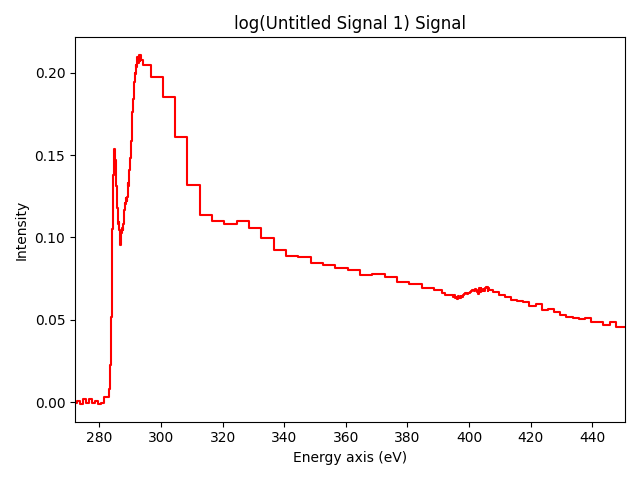

In [10]:
sp_part1 = extract_spectra(s_od_norm,M_part1)

In [11]:
sp_part1.save('sp_part1')

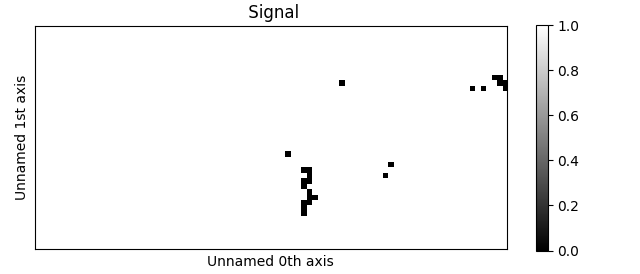

In [12]:
H = hs.signals.BaseSignal(G.data[1,:,:])
M_part2 = (H<0.8)+(M_trou+M_thick).transpose()+(s_od.isig[280.]>0.6).transpose()
M_part2.plot()

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


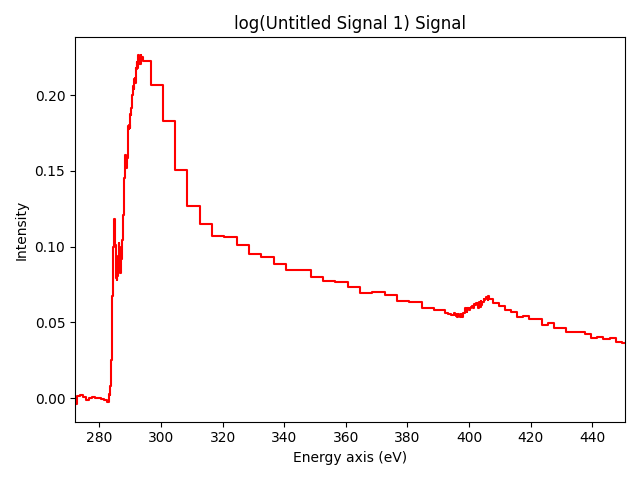

In [13]:
sp_part2 = extract_spectra(s_od_norm,M_part2)

In [14]:
sp_part2.save('sp_part2')

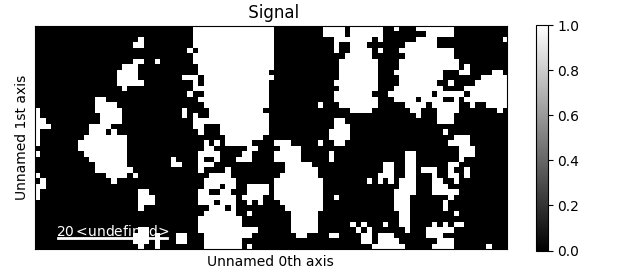

In [15]:
H = hs.signals.BaseSignal(G.data[2,:,:])
M_diff = (H<0.5)+(M_trou+M_trou+(s_od.isig[280.]>0.8)).transpose()
M_diff.plot()

/home/corentin/anaconda3/lib/python3.8/site-packages/hyperspy/signal.py:2451: UserWarning: Setting the `metadata` attribute is deprecated and will be removed in HyperSpy 2.0. Use the `set_item` and `add_dictionary` methods of the `metadata` attribute instead.
  warnings.warn(


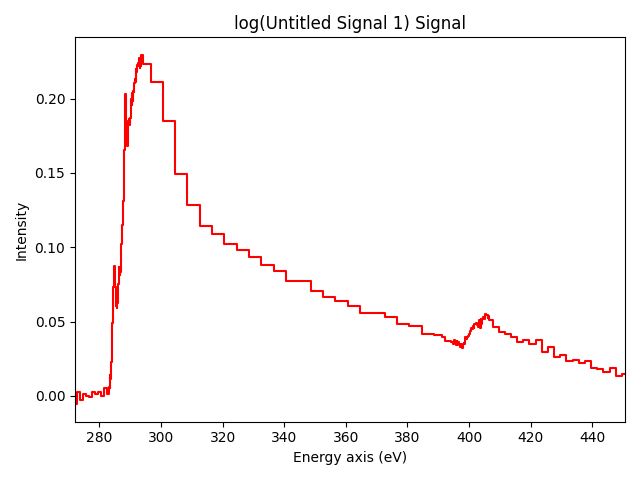

In [16]:
sp_diff = extract_spectra(s_od_norm,M_diff)

In [18]:
sp_diff.save('sp_diff')

In [21]:
legend=['Aromatic-rich particles', 'Ketone-bearing particles', 'Average diffuse OM']

Text(0, 0.5, 'Opt. Density (a.u.)')

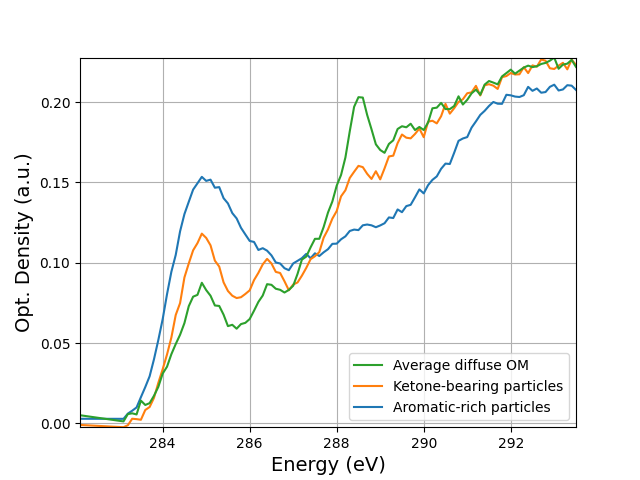

In [38]:
hs.plot.plot_spectra([sp_part1.isig[282.:294.], 
                      sp_part2.isig[282.:294.], 
                      sp_diff.isig[282.:294.],
                    #sp_carbonate.isig[282.:294.], 
                       #sp_thick.isig[282.:294.], 
],
                     legend=legend,
                    legend_loc='lower right',)
plt.grid()
plt.xlabel('Energy (eV)',size=14)
plt.ylabel('Opt. Density (a.u.)',size=14)

In [39]:
plt.gcf()
plt.savefig('Main_spectra', bbox_inches='tight')

In [19]:
M_part1.save('M_part1')
M_part2.save('M_part2')
M_diff.save('M_diff')
#M_carbonate.save('M_carbonate')
#M_thick.save('M_thick')

Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/M_part1.hspy' (y/n)?
 y
Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/M_part2.hspy' (y/n)?
 y
Overwrite '/win/Users/Corentin Le Guillou/Desktop/Sciences_et_avenir/XANES/SOLEIL_June2023/By_samples/Ryugu_Grain4_G3-2/M_diff.hspy' (y/n)?
 y
